In [1]:
# Import Dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite",echo=False)

In [6]:
# reflect an existing database into a new model
Base=automap_base()
# reflect the tables
Base.prepare(engine,reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session=Session(engine)

In [10]:
# Display the row's columns and ta in dictionary format for the Measurement table
Measurement_firstrow=session.query(Measurement).first()
Measurement_firstrow.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x28aedabcdd8>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'id': 1,
 'tobs': 65.0,
 'date': '2010-01-01'}

In [11]:
# Display the row's columns and ta in dictionary format for the Station table
Station_firstrow=session.query(Station).first()
Station_firstrow.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x28aedb05c18>,
 'id': 1,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397'}

# Exploratory Climate Analysis

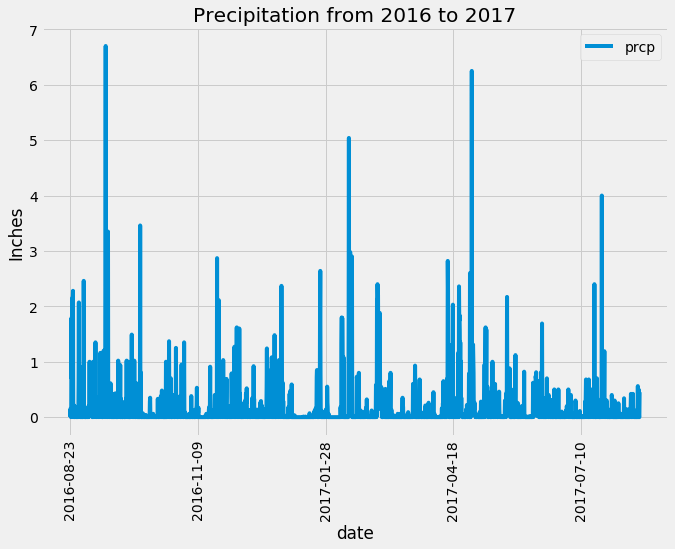

In [57]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

last_day=session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Got the result for 2017-08-23 for last_day
# One year ago from 2017-08-23 should be 2016-08-23

date_from_lastyear=dt.date(2017,8,23)-dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores and sort by date

prcp_per_date=session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date>=date_from_lastyear).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

prcp_per_date_df=pd.DataFrame(prcp_per_date).set_index('date')
prcp_per_date_df['prcp']=prcp_per_date_df.fillna(0)
# Sort the df by date
prcp_per_date_df=prcp_per_date_df.sort_values(by='date',ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
prcp_per_date_df.plot(rot=90,figsize=(10,7))
plt.ylabel('Inches')
plt.title(f"Precipitation from 2016 to 2017")
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_statistics=prcp_per_date_df.describe()
summary_statistics

,prcp
count,2230.000000
mean,0.160664
std,0.442067
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
station=session.query(Station.name).all()
station
# station=engine.execute('Select name from Station')
# station.fetchall()

[('WAIKIKI 717.2, HI US'),
 ('KANEOHE 838.1, HI US'),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('PEARL CITY, HI US'),
 ('UPPER WAHIAWA 874.3, HI US'),
 ('WAIMANALO EXPERIMENTAL FARM, HI US'),
 ('WAIHEE 837.5, HI US'),
 ('HONOLULU OBSERVATORY 702.2, HI US'),
 ('MANOA LYON ARBO 785.2, HI US')]

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations=session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print(f"The most active station is {most_active_stations[0]}")
# Query the table
station_table=engine.execute(f"Select * from Station").fetchall()
measurement_table=engine.execute(f"Select * from Measurement").fetchall()
# Convert them to df
station_table_df=pd.DataFrame(station_table,columns=['id','station','name','latitude','longtitude','elevation'])
measurement_table_df=pd.DataFrame(measurement_table,columns=['id','station','date','prcp','tobs'])

The most active station is ('USC00519281', 2772)


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
active_station=most_active_stations[0][0]
lowest_temp=session.query(func.min(Measurement.tobs)).filter_by(station=active_station).all()
highest_temp=session.query(func.max(Measurement.tobs)).filter_by(station=active_station).all()
avg_temp=session.query(func.avg(Measurement.tobs)).filter_by(station=active_station).all()
print(f"Lowest temperature recorded is {lowest_temp}")
print(f"Highest temperature recorded is {highest_temp}")
print(f"Average temperature recorded is {avg_temp}")

Lowest temperature recorded is [(54.0,)]
Highest temperature recorded is [(85.0,)]
Average temperature recorded is [(71.66378066378067,)]


Text(0.5, 1.0, 'Temperature for station USC00519397')

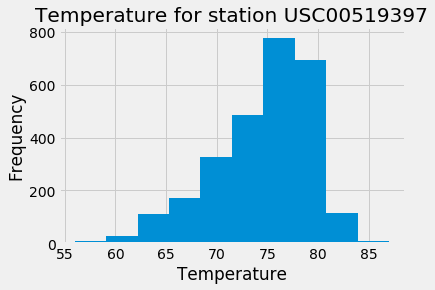

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest_tobs_station=session.query(Measurement.station,func.max(Measurement.tobs)).first()
last_observation=session.query(Measurement.date).\
    filter(Measurement.station==highest_tobs_station[0]).\
    order_by(Measurement.date.desc()).first()
# print(f"Last date of observation is {last_observation}")
year_ago=dt.datetime(2017,8,23)-dt.timedelta(days=365)
# Query the last 12 months of tobs for this station
tobs_total=session.query(Measurement.station,Measurement.tobs).\
filter(Measurement.station==highest_tobs_station[0]).order_by(Measurement.date).all()
# Put it to dataframe and set_index to 'station'
tobs_total_df=pd.DataFrame(tobs_total)
tobs_total_df.set_index('station',inplace=True)
# Plot the df
tobs_total_df.hist(by='station',rot=0)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title(f"Temperature for station {highest_tobs_station[0]}")

## Bonus Challenge Assignment

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temp_stats=calc_temps('2016-08-23','2017-08-23')
trip_temp_stats_df=pd.DataFrame(trip_temp_stats,columns=['min','avg','max'])
trip_temp_stats_df

,min,avg,max
0,58.0,74.590583,87.0


([], <a list of 0 Text xticklabel objects>)

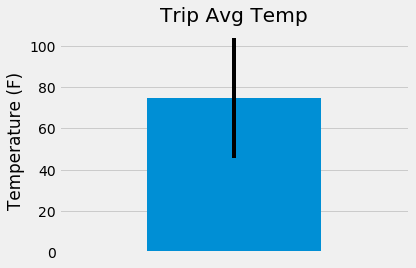

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr=trip_temp_stats_df.iloc[0]['max']-trip_temp_stats_df.iloc[0]['min']
trip_temp_stats_df['avg'].plot(kind='bar',yerr=yerr)
plt.ylabel('Temperature (F)')
plt.title('Trip Avg Temp')
plt.tight_layout()
plt.xticks([])

In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
merge_table=pd.merge(measurement_table_df,station_table_df,how='right',on='station')
merge_table=merge_table.drop(['id_x','id_y'],axis=1)
merge_table=merge_table.fillna(0)
trip_rainfal=merge_table.loc[merge_table['date']>='2016-08-23']
total_prcp=trip_rainfal.groupby(['station','name','latitude','longtitude','elevation'])['prcp'].sum()
total_prcp.sort_values(ascending=False)

station      name                                    latitude  longtitude  elevation
USC00516128  MANOA LYON ARBO 785.2, HI US            21.33310  -157.80250  152.4        147.81
USC00519281  WAIHEE 837.5, HI US                     21.45167  -157.84889  32.9          70.03
USC00513117  KANEOHE 838.1, HI US                    21.42340  -157.80150  14.6          48.51
USC00519523  WAIMANALO EXPERIMENTAL FARM, HI US      21.33556  -157.71139  19.5          38.01
USC00514830  KUALOA RANCH HEADQUARTERS 886.9, HI US  21.52130  -157.83740  7.0           33.24
USC00519397  WAIKIKI 717.2, HI US                    21.27160  -157.81680  3.0           16.09
USC00517948  PEARL CITY, HI US                       21.39340  -157.97510  11.9           4.59
Name: prcp, dtype: float64

In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [66]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals=[]
# Set the start and end date of the trip
start = ('2017-08-09')
end = ('2017-08-23')
# Use the start and end date to create a range of dates
date_range=pd.date_range(start,end)
cleaned_date_range=date_range.strftime('%m-%d')
# Strip off the year and save a list of %m-%d strings

# for date in date_range:
#     x=dt.datetime.strftime(date,'%m-%d')
#     normals.append(x)

# Loop through the list of %m-%d strings and calculate the normals for each date
# temp_list=[]
# for y in normals:
#     stats=daily_normals(y)
#     stats=list(np.ravel(stats))
#     temp_list.append(stats)

# min_list=[]
# max_list=[]
# avg_list=[]

# for z in temp_list:
#     min_list.append(temp_li[0])
#     max_list.append(temp_list[0][2])
#     avg_list.append(temp_list[0][1])

for x in cleaned_date_range:
    normals.append(*daily_normals(x))






[(69.0, 75.98039215686275, 81.0),
 (65.0, 76.42, 83.0),
 (67.0, 75.98113207547169, 82.0),
 (67.0, 76.52727272727273, 83.0),
 (71.0, 76.98245614035088, 84.0),
 (71.0, 76.77777777777777, 82.0),
 (69.0, 76.47169811320755, 83.0),
 (69.0, 76.08, 83.0),
 (69.0, 76.125, 83.0),
 (70.0, 76.92307692307692, 84.0),
 (69.0, 75.94642857142857, 85.0),
 (68.0, 76.45283018867924, 82.0),
 (67.0, 76.4, 83.0),
 (69.0, 76.47169811320755, 84.0),
 (67.0, 76.6923076923077, 87.0)]

In [69]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
temp_list_df=pd.DataFrame(normals,columns=['Tmin','Tavg','Tmax'])
temp_list_df['date']=cleaned_date_range
temp_list_df=temp_list_df.set_index('date')
temp_list_df

,Tmin,Tavg,Tmax
date,,,
08-09,69.0,75.980392,81.0
08-10,65.0,76.420000,83.0
08-11,67.0,75.981132,82.0
08-12,67.0,76.527273,83.0
08-13,71.0,76.982456,84.0
08-14,71.0,76.777778,82.0
08-15,69.0,76.471698,83.0
08-16,69.0,76.080000,83.0
08-17,69.0,76.125000,83.0


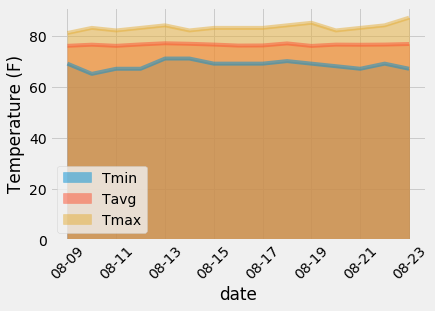

In [74]:
# Plot the daily normals as an area plot with `stacked=False`
temp_list_df.plot(kind='area',stacked=False,rot=45)
plt.ylabel('Temperature (F)')
plt.show()


